In [13]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [7]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Resize((128,128))
])

In [9]:
dataset_train = ImageFolder(
    "clouds/clouds_train",
    transform = train_transforms
)

In [15]:
dataloader_train = DataLoader(
    dataset_train,
    shuffle=True,
    batch_size=1
)

In [31]:
image, lable = next(iter(dataloader_train))
image = image.squeeze().permute(1,2,0)

In [33]:
print(image.shape)

torch.Size([128, 128, 3])


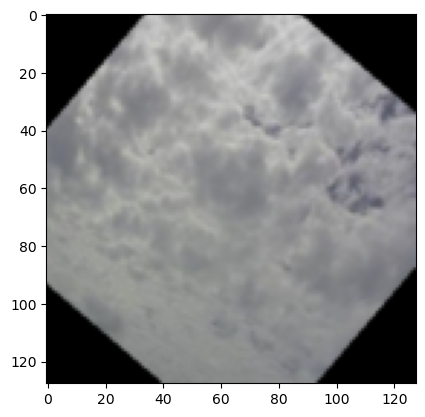

In [35]:
plt.imshow(image)
plt.show()